---
title: Understanding t-SNE by Implementing
date: 2021-10-30
tags: [NumPy, ML]
---

## Intro
t-SNE is an algorithm used to visualise high-dimensional data. Because we cannot visualise anything higher that has two - perhaps three - dimensions, it does this by reducing the number of dimensions in the data, and doing that with preserving the structure of data as much as possible. If we compare it to PCA we see that PCA tries to preserve the information in the data, while t-SNE would try to preserve the clustering and distances in the data, with less regard to the total preserved information.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

## General Procedure

As the aim is to reduce the dimensionality of the data, let's try to see how reducing two dimensional data to one dimension would work like.

![asdf](../assets/img/tsne/two2one.jpg)

As you can see the output of the algorithm is not just a project to the x axis, it transforms the dimensions such that the correlation between similar and dissimilar data is kept as much as possible.

If you take a look at the GIF below you can see how this procedure happens. At each iteration of the algorithm, similar data-points are pulled togather, and dissimilar points are pushed apart. This means that with enough iterations the algorithm should cluster the points in a similar way as their natural structure.

![gif](../assets/img/tsne/1d.gif)

## The Maths

Now let's look at how the algorithm actually works and the maths behind it. First of all we need to be able to determine if a pair of data points are similar. To do that we first calculate the euclidean distance between every pair of points.

In [2]:
def pairwise_distances(X):
    return np.sum((X[None, :] - X[:, None])**2, 2)

Then, we do the following procedure to calculate the similarities; for each data-point we place it in the middle of a gaussian curve and the rest of the data accordingly to their distances. This means that points closer to the middle are similar to the chosen one, while the one on the edges where very different.

This is reflected by the following formula which basiclally is normalized gaussian distribution;

$$p_{j|i} = \frac{exp(-||x_i - x_j||^2/2\sigma^2_i)}{\sum_{k\neq i}exp(-||x_i - x_k||^2/2\sigma^2_i)}$$

In [3]:
def p_conditional(dists, sigmas):
    e = np.exp(-dists / (2 * np.square(sigmas.reshape((-1,1)))))
    np.fill_diagonal(e, 0.)
    e += 1e-8
    return e / e.sum(axis=1).reshape([-1,1])

You may be wondering, how do we choose the $$\sigma$$ (standard deviation)? This we do not choose directly, but by choosing something called perplexity, which is defined by,

$$Perp(p) := 2^{-\sum_x p(x) \log_2 p(x)}$$

In [4]:
def perp(condi_matr):
    ent = -np.sum(condi_matr * np.log2(condi_matr), 1)
    return 2 ** ent

Perplexity basically defines our opinion of the density of the data. The best value cannot be really calculated analytically. So, we usually need to try out different values and try to find the one that provides the bast results. However, usually the most appropriate value for perplexity varies between 5 and 50.

With perplexity set by us the corresponding sigmas are chosen by the algorithm, by doing [binary search](https://en.wikipedia.org/wiki/Binary_search_algorithm).

In [5]:
def find_sigmas(dists, perplexity):
    found_sigmas = np.zeros(dists.shape[0])
    for i in range(dists.shape[0]):
        func = lambda sig: perp(p_conditional(dists[i:i+1, :], np.array([sig])))
        found_sigmas[i] = search(func, perplexity)
    return found_sigmas

In [6]:
def search(func, goal, tol=1e-10, max_iters=1000, lowb=1e-20, uppb=10000):
    for _ in range(max_iters):
        guess = (uppb + lowb) / 2.
        val = func(guess)

        if val > goal:
            uppb = guess
        else:
            lowb = guess

        if np.abs(val - goal) <= tol:
            return guess

    warnings.warn(f"\nSearch couldn't find goal, returning {guess} with value {val}")
    return guess

Now that we now how to find the similarities between the data in its original, high-dimensional state, we need to do the same for its low-dimensional representation. This way we will be able to know if data that is close togather in its original structure is also close togather in the projection.

This is a very similar procedure the only difference being that instead of using a gaussian distribution we will use a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), with [one degree of freedom](https://en.wikipedia.org/wiki/Cauchy_distribution).

$$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1 + ||y_k - y_l||^2)^{-1}}$$

This distribution is very similar to the Gaussian. It's just a bit higher on the edges, which makes the middle a bit lower.

![student](../assets/img/tsne/student.jpg)

In [7]:
def q_joint(y):
    dists = pairwise_distances(y)
    nom = 1 / (1 + dists)
    np.fill_diagonal(nom, 0.)
    return nom / np.sum(np.sum(nom))

We now know how to calculate the similarities both in high on low dimensional space. Next, we will do the iterations, where we will be picking steping and picking better and better representations of the data, using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

But in order to be able to calculate the gradient, we need a cost function, that is a way to check if the if the structure of the data in low dimensions represents the high-dimensional state accurately. Because we will be basiclally comparing two distributions, we use the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) for this.

I will not be showing the derivations to obtain the gradient here, if you are interested I suggest checking the Appendix in [the original paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) for this algorithm. If you go through the process the resulting gradient is the following,

$$\frac{\delta C}{\delta y_i} = 
4\sum_j (p_{ij} - q_{ij}) (y_i - y_j) (1 + ||y_i + y_j||^2)^{-1}$$

In [8]:
def gradient(P, Q, y):
    (n, no_dims) = y.shape
    pq_diff = P - Q
    y_diff = np.expand_dims(y,1) - np.expand_dims(y,0) 

    dists = pairwise_distances(y)
    aux = 1 / (1 + dists)
    return 4 * (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux,2)).sum(1)

With that the gradient descent procedure is basically as always, however we will use memontum here, which just a simple step function to make the learning at the beginning a bit quicker.

In [9]:
def m(t):
    return 0.5 if t < 250 else 0.8

There is only one thing left that I haven't told you yet. That is, what is called the crowding problem. The gist of this problem is that because we decrease the number of dimensions, the things that were are able to represent decrease aswell. To understand this, imagine a square where each of its edges is a data-point. Now try to represent these four points in a one dimensional space. You should see that there are a couple of combinations of results you will achieve were none of them fill right because you cannot the fact that they all have equal distance to two others. This basically is the crowding problem. To try to solve this problem, set

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$$

In [10]:
def p_joint(X, perp):
    N = X.shape[0]
    dists = pairwise_distances(X)
    sigmas = find_sigmas(dists, perp)
    p_cond = p_conditional(dists, sigmas)
    return (p_cond + p_cond.T) / (2. * N)

Now we know everything to implement the t-SNE algorithm.

In [11]:
def tsne(X, ydim=2, T=1000, l=500, perp=30):
    N = X.shape[0]
    P = p_joint(X, perp)

    Y = []
    y = np.random.normal(loc=0.0, scale=1e-4, size=(N,ydim))
    Y.append(y); Y.append(y)

    for t in range(T):
        Q = q_joint(Y[-1])
        grad = gradient(P, Q, Y[-1])
        y = Y[-1] - l*grad + m(t)*(Y[-1] - Y[-2])
        Y.append(y)
        if t % 10 == 0:
            Q = np.maximum(Q, 1e-12)
    return y

## Results

We can quikly run it on [the MNIST digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits), and see that it thas cluster different digits in separate clusters, which exactly what we would like to see.

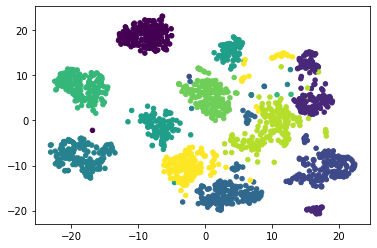

In [12]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
res = tsne(X, T=1000, l=200, perp=40)
plt.scatter(res[:, 0], res[:, 1], s=20, c=y)
plt.show()

But let's now generate some data to check how it works on different structures. I will generate data of only 2 dimensions run on t-SNE to get two dimensions. Only this practically wouldn't make sense, I do it here to be able to visualise the results so we can examine them better.

First, different distances. If you look at the results below, you can see that the distances between clusters are not preserved for all the results. This, shows the importance of choosing the correct perplexity the keep the original structure as much as possible

In [33]:
def plot2d(data, labels, perps=[30], iters=400):
    np.random.seed(123)
    f, axs = plt.subplots(1, len(perps)+1, figsize=(12,24))
    f.tight_layout()
    axs[0].axis('off')
    axs[0].scatter(data[:, 0], data[:, 1], c=labels)
    axs[0].title.set_text('Original')
    axs[0].axis('square')
    
    for i, perp in enumerate(perps):
        axs[i+1].axis('off')
        res = tsne(data, T=iters, l=200, perp=perp)
        axs[i+1].scatter(res[:, 0], res[:, 1], s=20, c=labels)
        axs[i+1].title.set_text(f'Perplexity: {perp}')
        axs[i+1].axis('square')
    plt.show()

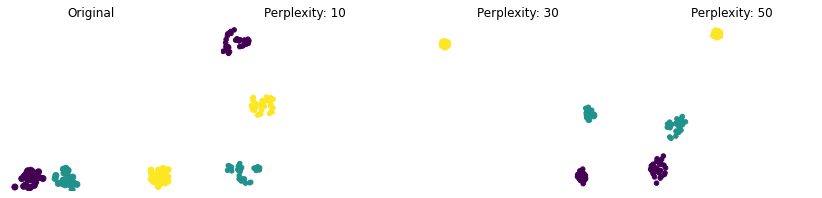

In [34]:
size = 30
d1 = np.random.multivariate_normal([-5, 0], [[2,0],[0,2]], size=size)
d2 = np.random.multivariate_normal([5, 0], [[2,0],[0,2]], size=size)
d3 = np.random.multivariate_normal([30, 0], [[2,0],[0,2]], size=size)
d = np.concatenate((d1, d2, d3), axis=0)
l = [0] * size + [1] * size + [2] * size
plot2d(d, l, perps=[10,30,50])

Next, we try clusters with different densities. Here, we see that the densities of the clusters created by t-SNE become about the same. The reason for this is that when we calculate the similarities we normalise the results. This causes the clusters to have similar sizes although it is not how the original data looks like.

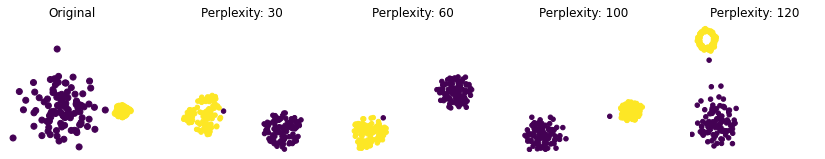

In [35]:
size = 100
d1 = np.random.multivariate_normal([-8, 0], [[20,0],[0,20]], size=size)
d2 = np.random.multivariate_normal([8, 0], [[0.5,0],[0,0.5]], size=size)
d = np.concatenate((d1, d2), axis=0)
l = [0] * size + [1] * size
plot2d(d, l, perps=[30,60,100,120])

We can also see that the algoithm can distinguish a denser region inside a cluster as a different cluster, which is pretty impresive. Do note, however that the perplexity set will change the results, so we do need to represent our knowledge of the data through the perplexity or try out different values to compare the results.

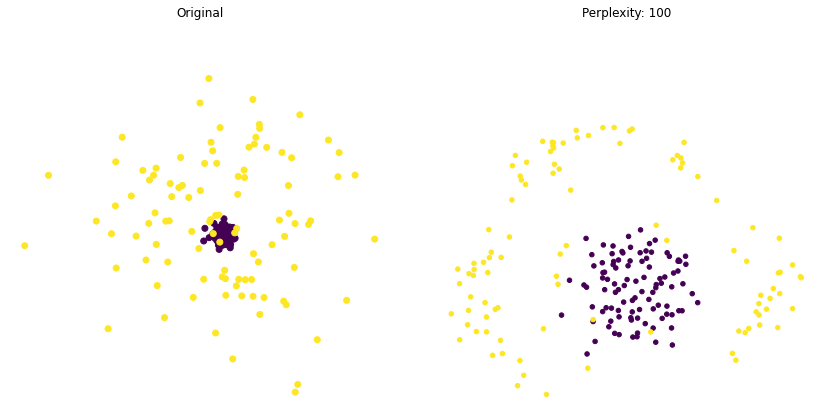

In [36]:
size = 100
d1 = np.random.multivariate_normal([0, 0], [[0.5,0],[0,0.5]], size=size)
d2 = np.random.multivariate_normal([0, 0], [[80,0],[0,80]], size=size)
d = np.concatenate((d1, d2), axis=0)
l = [0] * size + [1] * size
plot2d(d, l, perps=[100])

Lastly, one more example as it looks very cool. However, if you look at the result obtained by 50 perplexity you can see that the middle of the clusters is pushed out more compared to the rest of the data-points. This is caused by the fact that these regions are more dense so the push-pull affects become greater.

If you are interested seeing more examples of t-SNE's results on different structures of data and its limits I suggest checking out [distill.pub](https://distill.pub/2016/misread-tsne/).

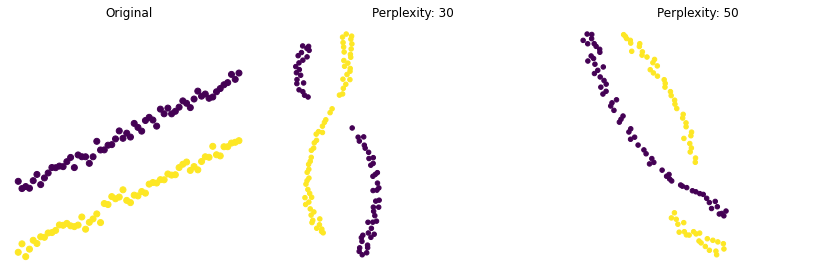

In [37]:
size = 60
xt = np.linspace(0,100,size)
d1 = xt * 0.5 + 30 + np.random.normal(0,2,size=size)
d2 = xt * 0.5 + 1 + np.random.normal(0,2,size=size)
d = np.concatenate((d1.reshape([-1,1]), d2.reshape([-1,1])), axis=0)
tmp = np.concatenate((xt.reshape([-1,1]),xt.reshape([-1,1])), axis=0)
d = np.concatenate((tmp, d), axis=1)
l = [0] * size + [1] * size
plot2d(d, l, perps=[30,50])

To close we can compare results obtained by t-SNE to PCA to clearly see that t-SNE aims to cluster the data and therefore makes the visualisations much more useful while trying to cluster the data.

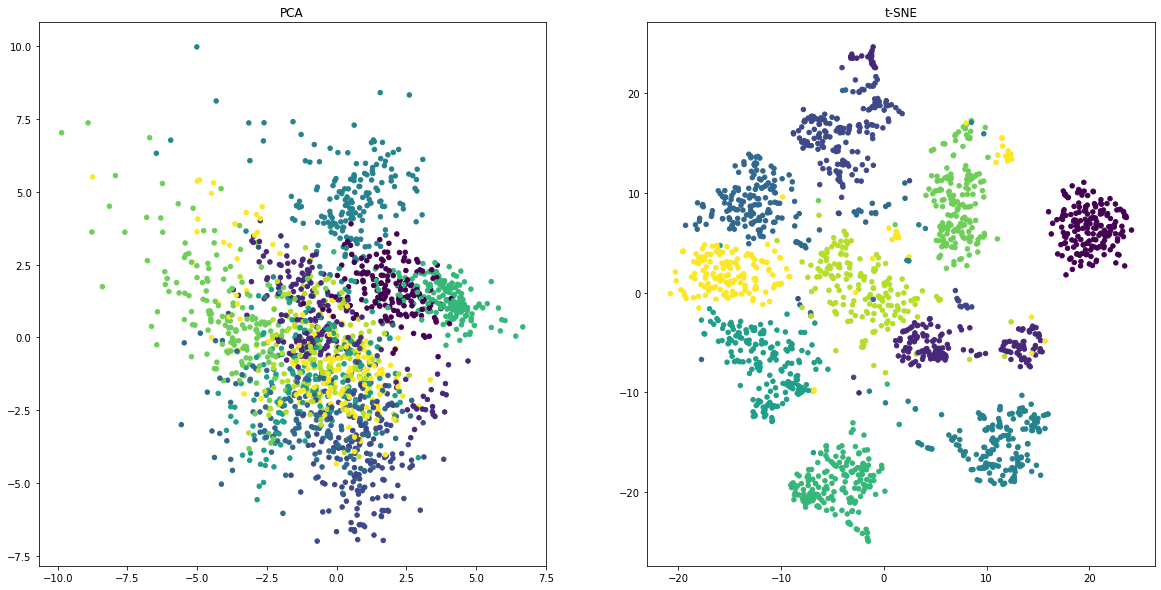

In [44]:
from scipy.linalg import eigh
from sklearn.preprocessing import StandardScaler

def pca(high_dimesion_data):
    #find the co-variance matrix which is : A^T * A
    sample_data = high_dimesion_data
    # matrix multiplication using numpy
    covar_matrix = np.matmul(sample_data.T , sample_data)
    # this code generates only the top 2 (782 and 783)(index) eigenvalues.
    _, vectors = eigh(covar_matrix, eigvals=(62,63))
    
    return np.matmul(vectors.T, sample_data.T).T

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
res = pca(X_scaled)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.scatter(res[:, 0], res[:, 1], s=20, c=y)
ax1.title.set_text('PCA')

res = tsne(X_scaled, T=1000, l=200, perp=40)
ax2.scatter(res[:, 0], res[:, 1], s=20, c=y)
ax2.title.set_text('t-SNE')
plt.show()